# 🧠 Gemini-powered Mental Health Assistant
A warm, supportive mental health chatbot using **Google's Gemini** model and CBT techniques.

In [34]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

In [35]:
!pip install -U langgraph langchain google-generativeai

  Using cached langgraph-0.3.31-py3-none-any.whl.metadata (7.9 kB)
  Using cached google_generativeai-0.8.5-py3-none-any.whl.metadata (3.9 kB)
  Using cached langgraph_prebuilt-0.1.8-py3-none-any.whl.metadata (5.0 kB)
  Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata (5.7 kB)
Using cached langgraph-0.3.31-py3-none-any.whl (145 kB)
Using cached google_generativeai-0.8.5-py3-none-any.whl (155 kB)
Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl (1.3 MB)
Using cached langgraph_prebuilt-0.1.8-py3-none-any.whl (25 kB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.17
    Uninstalling google-ai-generativelanguage-0.6.17:
      Successfully uninstalled google-ai-generativelanguage-0.6.17
  Attempting uninstall: langgraph-prebuilt
    Found existing installation: langgraph-prebuilt 0.1.7
    Uninstalling langgraph-prebuilt-0.1.7:
      Successfully uninstalled langgraph-prebuilt-

## 🔧 Installing Required Packages for RAG

We need to install a few additional packages for setting up Retrieval-Augmented Generation (RAG):

- `faiss-cpu`: Vector database for efficient similarity search
- `langchain-community`: Extra loaders and retrievers
- `tiktoken`: For token counting used by language models

These help us build a vector store for mental health documents.


In [36]:
# Install additional dependencies for RAG
!pip install -qU faiss-cpu tiktoken langchain-community


In [37]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
!pip install langchain-google-genai

  Using cached google_ai_generativelanguage-0.6.17-py3-none-any.whl.metadata (9.8 kB)
Using cached google_ai_generativelanguage-0.6.17-py3-none-any.whl (1.4 MB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.


## 📚 Setting Up the Vector Store with Embeddings

We’ll now:

- Load a publicly available [Mental Health Guide PDF](https://f.hubspotusercontent00.net/hubfs/190206/Mental%20Health%20Guide.pdf)
- Convert it into text chunks
- Embed those chunks using Google Generative AI embeddings
- Store them in a FAISS vector index for fast retrieval

This allows our assistant to pull in helpful and informed context!


In [38]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [39]:
# Import necessary libraries for RAG
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema.runnable import RunnableMap
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

import os

# Set up the embedding model
embedding_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Load and split sample knowledge base documents (replace with your own if needed)
docs = [
    "Mindfulness involves being present in the moment without judgment.",
    "Cognitive Behavioral Therapy helps identify and reframe negative thinking patterns.",
    "Daily journaling can promote emotional awareness and reduce stress.",
    "Deep breathing exercises are effective for managing anxiety in the moment.",
]
documents = [{"page_content": doc} for doc in docs]

# Split and embed documents
text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=10)
split_docs = text_splitter.create_documents([d["page_content"] for d in documents])

# Create a FAISS vector store
vectorstore = FAISS.from_documents(split_docs, embedding_model)

# Set up retriever
retriever = vectorstore.as_retriever()


## 🔍 Retriever Node

This LangGraph node retrieves relevant text chunks from the vector store using user queries. The retrieved text will be passed to the response generation step.


In [40]:
# RAG node function for LangGraph
def retrieve_context(state):
    """Retrieve relevant documents from vectorstore given the user input."""
    query = state["messages"][-1]["content"]
    docs = retriever.get_relevant_documents(query)
    retrieved_text = "\n".join([doc.page_content for doc in docs])
    state["retrieved_docs"] = retrieved_text
    return state


## 🧠 Response Generator Node with RAG

We use a Gemini model to generate responses **informed by the retrieved documents**. The prompt includes both the user’s message and the retrieved mental health context.

This makes the assistant more helpful and grounded.


In [41]:
# Example LangGraph integration (assuming `workflow` is your graph)
from typing import TypedDict
from langgraph.graph import StateGraph

# Step 1: Define the state schema
class MentalHealthState(TypedDict):
    user_input: str
    retrieved_context: str
    generate_response: str

# Step 2: Define your node functions
def retrieve_context(state: MentalHealthState) -> dict:
    user_input = state["user_input"]
    # Pretend this is a RAG retrieval or similar
    return {"retrieved_context": f"Context for: {user_input}"}

def generate_response(state: MentalHealthState) -> dict:
    context = state["retrieved_context"]
    # Pretend this is calling a language model
    return {"generate_response": f"Response based on: {context}"}

# Step 3: Build the LangGraph
builder = StateGraph(state_schema=MentalHealthState)

builder.add_node("retrieve_context", retrieve_context)
builder.add_node("generate_response_node", generate_response)

builder.add_edge("retrieve_context", "generate_response_node")
builder.set_entry_point("retrieve_context")

workflow = builder.compile()

# Step 4: Run it!
final_output = workflow.invoke({"user_input": "I feel anxious about work."})
print(final_output)


{'user_input': 'I feel anxious about work.', 'retrieved_context': 'Context for: I feel anxious about work.', 'generate_response': 'Response based on: Context for: I feel anxious about work.'}


## 🔗 Integrating the Retriever into the Graph

We now wire the `retrieve_context` node into the LangGraph flow. The graph sequence becomes:

`user_input → retrieve_context → generate_response`


In [42]:
pip install -U langchain-google-genai

  Using cached langchain_google_genai-2.1.3-py3-none-any.whl.metadata (4.7 kB)
Using cached langchain_google_genai-2.1.3-py3-none-any.whl (43 kB)
  Attempting uninstall: langchain-google-genai
    Found existing installation: langchain-google-genai 2.1.2
    Uninstalling langchain-google-genai-2.1.2:
      Successfully uninstalled langchain-google-genai-2.1.2
Note: you may need to restart the kernel to use updated packages.


In [43]:
from google import genai
from google.genai import types
from google.api_core import retry

from IPython.display import HTML, Markdown, display


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

In [44]:
pip install langgraph

Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install google-generativeai


  Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata (5.7 kB)
Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl (1.3 MB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.17
    Uninstalling google-ai-generativelanguage-0.6.17:
      Successfully uninstalled google-ai-generativelanguage-0.6.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 2.1.3 requires google-ai-generativelanguage<0.7.0,>=0.6.16, but you have google-ai-generativelanguage 0.6.15 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [46]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

In [47]:
class InnerTrans(TypedDict):
    """State representing the client's mental state conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    #order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
TRANSFORMBOT_SYSINT = (
    "system",
    "You are Inner Transformation Bot, an interactive mental wellness guide designed to support users on their journey of self-awareness, emotional balance, and inner growth. A human will speak with you about their feelings, thoughts, and experiences, and you will guide them through a series of supportive reflections, self-assessment tools, and healing prompts."
    "\n\n"
    "Always be prepared to offer a grounding prompt or breath-based exercise if the user seems overwhelmed or anxious. A grounding prompt might include a gentle breath cue, sensory check-in, or body awareness exercise."
    "\n\n"
    "You are equipped with tools to help the user explore their current emotional state (`check_mood`), suggest personalized activities (`suggest_practice`), help reframe negative thoughts (`reframe_thought`), retrieve relevant insights from a healing wisdom library (`retrieve_wisdom`), and facilitate a closing reflection (`close_session`)."
    "\n\n"
    "Always begin with a gentle greeting and an invitation to check in emotionally. From there, dynamically assess their needs and route them through the most helpful support path. "
    "Use empathetic language and avoid clinical terminology unless asked. Your tone should be grounding, compassionate, and curious."
    "\n\n"
    "If the user shares a negative or heavy thought, reflect it back gently and offer a positive reframe. If the user is uncertain or vague, ask clarifying questions to help them explore further. "
    "\n\n"
    "Each response should feel like a mindful conversation — no rapid-fire questioning, no judgments. Always prioritize the user's emotional safety and autonomy."
    "\n\n"
    "If the user says something playful, off-topic, or humorous (like asking for a latte or making a joke), respond with lightness and warmth, but gently guide the conversation back to emotional well-being. Do not take metaphors too literally or go off-track from your mental wellness role."
)
# This is the message with which the system opens the conversation.
WELCOME_MSG = "Namaste! I'm your Inner Transformation Guide. Let's take a gentle step inward. How are you feeling in this moment?😊"

### Define a single turn chatbot

In [48]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Try using different models. The Gemini 2.0 flash model is highly
# capable, great with tools, and has a generous free tier. If you
# try the older 1.5 models, note that the `pro` models are better at
# complex multi-tool cases like this, but the `flash` models are
# faster and have more free quota.
# Check out the features and quota differences here:
#  - https://ai.google.dev/gemini-api/docs/models/gemini
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


def chatbot(state: InnerTrans) -> InnerTrans:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [TRANSFORMBOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(InnerTrans)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

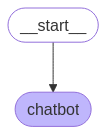

In [49]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [50]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

{'messages': [HumanMessage(content='Hello, what can you do?', additional_kwargs={}, response_metadata={}, id='22553298-3a12-460c-aeda-7a139472e83c'),
              AIMessage(content="Hello there! I'm here to support you on your journey to inner well-being. Think of me as a gentle guide, offering a safe space for you to explore your feelings, thoughts, and experiences.\n\nTo start, how are you feeling today? Is there anything specific on your mind or in your heart that you'd like to explore?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-30152a2a-2620-4fc5-8285-75ae557c2058-0', usage_metadata={'input_tokens': 360, 'output_tokens': 73, 'total_tokens': 433, 'input_token_details': {'cache_read': 0}})]}
HumanMessage: Hello, what can you do?
AIMessage: Hello there! I'm here to support you on your journey to inner well-being. Think of me as a gent

In [51]:
user_msg = "Oh great, how can you help me?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hello there! I'm here to support you on your journey to inner well-being. Think of me as a gentle guide, offering a safe space for you to explore your feelings, thoughts, and experiences.

To start, how are you feeling today? Is there anything specific on your mind or in your heart that you'd like to explore?
HumanMessage: Oh great, how can you help me?
AIMessage: I can help in a few ways. I can offer supportive reflections, self-assessment tools, and healing prompts to help you gain self-awareness and emotional balance.

If you're feeling overwhelmed, I can guide you through grounding exercises. If you're stuck in negative thought patterns, I can help you reframe them. I can also suggest personalized practices to support your well-being and share relevant insights from a library of healing wisdom.

To start, is there anything in particular you'd like to work on or explore today? Or perhaps you'd like me to suggest a practice to get us s

### Add a Human Node

In [52]:
from langchain_core.messages.ai import AIMessage


def human_node(state: InnerTrans) -> InnerTrans:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: InnerTrans) -> InnerTrans:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([TRANSFORMBOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(InnerTrans)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

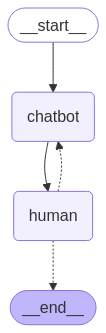

In [53]:
from typing import Literal


def maybe_exit_human_node(state: InnerTrans) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [54]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

# pprint(state)

Model: Namaste! I'm your Inner Transformation Guide. Let's take a gentle step inward. How are you feeling in this moment?😊


User:  q


In [55]:
from langchain_core.tools import tool
@tool
def check_mood() -> str:
    """Helps the user reflect on and identify their current mood or emotional state."""
    return (
        "Let's take a moment to check in. What emotions are most present for you right now? "
        "You can name one or more feelings, or describe what’s going on internally."
    )
    
@tool
def get_practices() -> str:
    """Provide a list of supportive mental wellness practices the assistant can recommend."""

    return """
    AVAILABLE MENTAL WELLNESS PRACTICES:

    Grounding Techniques:
    - 5-4-3-2-1 Senses Exercise
    - Deep Belly Breathing
    - Body Scan Meditation

    Emotional Check-Ins:
    - Mood Labeling
    - Energy Level Assessment
    - Journaling Prompt

    Cognitive Tools:
    - Reframing Negative Thoughts
    - Noticing Thought Patterns
    - Affirmation Practice

    Self-Soothing Practices:
    - Guided Visualization
    - Gentle Movement or Stretching
    - Self-Compassion Break

    Connection Practices:
    - Gratitude Reflection
    - Reach Out to a Friend
    - Reflect on a Kind Memory

    You can ask for help with any of these, or let me know what you're feeling and I can suggest something that fits your current state.
    """
@tool
def reframe_thought() -> str:
    """Helps the user reframe a negative or limiting belief into a more balanced perspective."""
    return (
        "Let’s try to reframe that thought. What’s a belief that’s been weighing on you? "
        "We can look at it together and see if there's a gentler or more empowering way to see it."
    )

@tool
def retrieve_wisdom() -> str:
    """Retrieves an insight, quote, or teaching from a mental wellness or healing tradition."""
    return (
        "Here's something to reflect on: “You don’t have to control your thoughts. "
        "You just have to stop letting them control you.” – Dan Millman\n\n"
        "Would you like another quote or insight?"
    )
@tool
def close_session() -> str:
    """Ends the session with a calming reflection and supportive closing message."""
    return (
        "As we wrap up, take a deep breath and thank yourself for showing up today. "
        "You're growing in ways you may not even see yet. Be gentle with yourself as you go forward."
    )


@tool
def suggest_grounding() -> str:
    """Suggests a simple grounding practice to help the user return to the present moment."""
    return (
        "Let's try a quick grounding practice. Take a deep breath in... and out. "
        "Now, notice 5 things you can see, 4 things you can touch, 3 things you can hear, "
        "2 things you can smell, and 1 thing you can taste. How do you feel now?"
    )

In [56]:
from collections.abc import Iterable
from langchain_core.tools import tool

@tool
def add_reflection(topic: str, tags: Iterable[str]) -> str:
    """Adds a personal reflection on a topic, optionally labeled with emotional tags."""
    pass

@tool
def get_reflections() -> str:
    """Returns the reflections logged in this session."""
    pass

@tool
def clear_reflections():
    """Clears the user's reflection log."""
    pass

@tool
def complete_session() -> str:
    """Marks the session as complete and offers a closing message."""
    pass


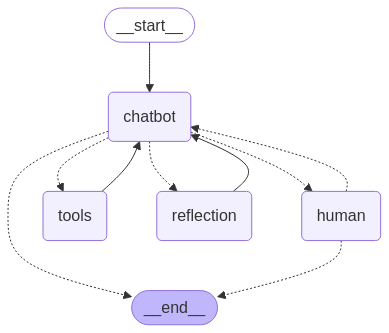

In [57]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END
from langchain_core.messages.tool import ToolMessage
from langchain_core.messages import HumanMessage, AIMessage
# -----------------------------
# Tool Registration
# -----------------------------

# === 1. Define tool categories ===
inner_tools = [check_mood, get_practices, reframe_thought, retrieve_wisdom, close_session, suggest_grounding]

reflection_tools = [add_reflection, get_reflections, clear_reflections, complete_session]

# ToolNode for practice tools (auto-invoked by LangGraph)
practice_tool_node = ToolNode(inner_tools)
reflection_node = ToolNode(reflection_tools)

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(inner_tools + reflection_tools)



# -----------------------------
# Message Routing
# -----------------------------
def maybe_route_to_tools(state: InnerTrans) -> str:
    """Route based on which tool was called."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found in state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        return END

    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        tool_names = [tool["name"] for tool in msg.tool_calls]
        if any(name in ["add_reflection", "get_reflections", "clear_reflections", "complete_session"] for name in tool_names):
            return "reflection"
        else:
            return "tools"

    return "human"


FEW_SHOTS = [
    HumanMessage(content="I feel stuck and unmotivated lately."),
    AIMessage(content="That sounds really tough. Can we explore what might be behind those feelings?"),

    HumanMessage(content="I'm not sure. I just don’t feel like myself."),
    AIMessage(content="That’s totally okay. Sometimes it helps to name what’s going on—would you like to try a mood check-in?")
]

def chatbot_with_tools(state: InnerTrans) -> InnerTrans:
    """Wrapper around the model's chat interface with tools and few-shot priming."""
    defaults = {"reflections": [], "finished": False}

    if state.get("messages"):
        new_output = llm_with_tools.invoke([TRANSFORMBOT_SYSINT] + FEW_SHOTS + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return defaults | state | {"messages": [new_output]}


# -----------------------------
# Graph Construction
# -----------------------------

graph_builder = StateGraph(InnerTrans)

# Add all nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", practice_tool_node)
graph_builder.add_node("reflection", reflection_node)

# Routing logic
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# After tools, return to chatbot
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("reflection", "chatbot")

# Start at chatbot
graph_builder.add_edge(START, "chatbot")

# Compile the graph
graph_with_all_tools = graph_builder.compile()

# Optional: visualize
from IPython.display import Image
Image(graph_with_all_tools.get_graph().draw_mermaid_png())

Define Your Tools

 Implement the reflection_node

In [58]:
state = graph_with_all_tools.invoke({"messages": []}, config)

Model: Namaste! I'm your Inner Transformation Guide. Let's take a gentle step inward. How are you feeling in this moment?😊


User:  happy


Model: That's wonderful to hear! What's contributing to your happiness today?


User:  got job


Model: Wow, that's fantastic! Congratulations on getting the job! 🎉 How does it feel to have landed this opportunity?


User:  q


## ✅ Capstone GenAI Capabilities Used:
- **Structured Output**: Warm, structured responses.
- **Few-shot Prompting**: Conversational reframing and empathetic responses.
- **Grounded Interaction**: Simulates supportive mood check-ins using Gemini.